In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
from catboost import CatBoostClassifier, CatBoostRegressor
from autogluon.tabular import TabularDataset, TabularPredictor
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import data
obs_A = pd.read_parquet('../../preprocessing/data/obs_A.parquet')
obs_B = pd.read_parquet('../../preprocessing/data/obs_B.parquet')
obs_C = pd.read_parquet('../../preprocessing/data/obs_C.parquet')
est_A = pd.read_parquet('../../preprocessing/data/est_A.parquet')
est_B = pd.read_parquet('../../preprocessing/data/est_B.parquet')
est_C = pd.read_parquet('../../preprocessing/data/est_C.parquet')
test_A = pd.read_parquet('../../preprocessing/data/test_A.parquet').drop(columns='date_forecast')
test_B = pd.read_parquet('../../preprocessing/data/test_B.parquet').drop(columns='date_forecast')
test_C = pd.read_parquet('../../preprocessing/data/test_C.parquet').drop(columns='date_forecast')

In [3]:
# Concatinate
A = pd.concat([obs_A, est_A])
B = pd.concat([obs_B, est_B])
C = pd.concat([obs_C, est_C])

A.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in A.columns]
B.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in B.columns]
C.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in C.columns]

# Step 1: Filter A to include only months from March to October
A = A[A['date_forecast'].dt.month.isin([3, 4, 5, 6, 7, 8, 9, 10])]

# Step 2: Identify unique days within May, June, and July
summer_months = A[A['date_forecast'].dt.month.isin([5, 6, 7])]
unique_summer_days = summer_months['date_forecast'].dt.date.unique()

# Step 3: Sample these days for val_A
sampled_days = np.random.choice(unique_summer_days, size=int(len(unique_summer_days) * 0.2), replace=False)
val_A = A[A['date_forecast'].dt.date.isin(sampled_days)]

# Step 4: Define train_A as the remaining data
train_A = A[~A['date_forecast'].dt.date.isin(sampled_days)]

# Prepare your features and target variables
X_train_A = train_A.drop(columns='pv_measurement')
y_train_A = train_A['pv_measurement']
X_val_A = val_A.drop(columns='pv_measurement')
y_val_A = val_A['pv_measurement']

# Repeat for B and C
B = B[B['date_forecast'].dt.month.isin([3, 4, 5, 6, 7, 8, 9, 10])]
summer_months = B[B['date_forecast'].dt.month.isin([5, 6, 7])]
unique_summer_days = summer_months['date_forecast'].dt.date.unique()
sampled_days = np.random.choice(unique_summer_days, size=int(len(unique_summer_days) * 0.2), replace=False)
val_B = B[B['date_forecast'].dt.date.isin(sampled_days)]
train_B = B[~B['date_forecast'].dt.date.isin(sampled_days)]
X_train_B = train_B.drop(columns='pv_measurement')
y_train_B = train_B['pv_measurement']
X_val_B = val_B.drop(columns='pv_measurement')
y_val_B = val_B['pv_measurement']

C = C[C['date_forecast'].dt.month.isin([3, 4, 5, 6, 7, 8, 9, 10])]
summer_months = C[C['date_forecast'].dt.month.isin([5, 6, 7])]
unique_summer_days = summer_months['date_forecast'].dt.date.unique()
sampled_days = np.random.choice(unique_summer_days, size=int(len(unique_summer_days) * 0.2), replace=False)
val_C = C[C['date_forecast'].dt.date.isin(sampled_days)]
train_C = C[~C['date_forecast'].dt.date.isin(sampled_days)]
X_train_C = train_C.drop(columns='pv_measurement')
y_train_C = train_C['pv_measurement']
X_val_C = val_C.drop(columns='pv_measurement')
y_val_C = val_C['pv_measurement']

# Drop date_forecast
X_train_A = X_train_A.drop(columns='date_forecast')
X_train_B = X_train_B.drop(columns='date_forecast')
X_train_C = X_train_C.drop(columns='date_forecast')
X_val_A = X_val_A.drop(columns='date_forecast')
X_val_B = X_val_B.drop(columns='date_forecast')
X_val_C = X_val_C.drop(columns='date_forecast')

In [4]:
# print(A.columns)
# print(X_train_A['month'].describe())
# print(X_val_A['month'].describe())

In [5]:
train_lgbm_A = lgb.Dataset(X_train_A, label=y_train_A)
val_lgbm_A = lgb.Dataset(X_val_A, label=y_val_A, reference=train_lgbm_A)

train_lgbm_B = lgb.Dataset(X_train_B, label=y_train_B)
val_lgbm_B = lgb.Dataset(X_val_B, label=y_val_B, reference=train_lgbm_B)

train_lgbm_C = lgb.Dataset(X_train_C, label=y_train_C)
val_lgbm_C = lgb.Dataset(X_val_C, label=y_val_C, reference=train_lgbm_C)

train_auto_A = TabularDataset(train_A)
val_auto_A = TabularDataset(val_A)

train_auto_B = TabularDataset(train_B)
val_auto_B = TabularDataset(val_B)

train_auto_C = TabularDataset(train_C)
val_auto_C = TabularDataset(val_C)

auto_label = 'pv_measurement'

# Set the parameters for the LGBM models
params = {
    'boosting_type': 'dart',
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 100,
    'learning_rate': 0.05,
    'verbose': 1
}

# Set the parameters for the XGBoost models
parameters_A = {
    'colsample_bytree': 0.8, 
    'gamma': 0.4, 
    'learning_rate': 0.012, 
    'max_depth': 15, 
    'min_child_weight': 10, 
    'n_estimators': 600, 
    'reg_alpha': 0.8, 
    'reg_lambda': 0.8, 
    'subsample': 0.912,
    'random_state': 0, 
    'booster': 'gbtree',
    'n_jobs': -1,
    'eval_set': [(X_train_A, y_train_A), (X_val_A, y_val_A)],
    'num_parallel_tree': 5
}

parameters_B = {
    'colsample_bytree': 0.8, 
    'gamma': 0.8, 
    'learning_rate': 0.008, 
    'max_depth': 15, 
    'min_child_weight': 10, 
    'n_estimators': 600, 
    'reg_alpha': 1, 
    'reg_lambda': 3, 
    'subsample': 0.912,
    'random_state': 0, 
    'booster': 'gbtree',
    'n_jobs': -1,
    'eval_set': [(X_train_B, y_train_B), (X_val_B, y_val_B)]
}

parameters_C = {
    'colsample_bytree': 0.8, 
    'gamma': 0.8, 
    'learning_rate': 0.008, 
    'max_depth': 15, 
    'min_child_weight': 10, 
    'n_estimators': 600, 
    'reg_alpha': 1, 
    'reg_lambda': 3, 
    'subsample': 0.912,
    'random_state': 0, 
    'booster': 'gbtree',
    'n_jobs': -1,
    'eval_set': [(X_train_C, y_train_C), (X_val_C, y_val_C)]
}

xgb_A = xgb.XGBRegressor(**parameters_A)
xgb_B = xgb.XGBRegressor(**parameters_B)
xgb_C = xgb.XGBRegressor(**parameters_C)

cat_A = CatBoostRegressor(
    iterations=3000,        # The number of trees to build
    #learning_rate=0.09,     # The learning rate
    #depth=10,               # Depth of the tree
    loss_function='MAE',     # Loss function to be optimized. RMSE is common for regression.
    eval_metric='MAE',       # Evaluation metric for the validation set
    #random_seed=42,         # Seed for reproducibility
    #verbose=100             # Frequency of logging the training process
)

cat_B = CatBoostRegressor(
    iterations=3000,
    #learning_rate=0.09,
    #depth=10,
    loss_function='MAE',
    eval_metric='MAE',
    #random_seed=42,
    #verbose=100
)

cat_C = CatBoostRegressor(
    iterations=3000,
    #learning_rate=0.09,
    #depth=10,
    loss_function='MAE',
    eval_metric='MAE',
    #random_seed=42,
    #verbose=100
)


In [6]:
# Train the LGBM models

lgbm_A = lgb.train(params,
                train_lgbm_A,
                num_boost_round=500,
                valid_sets=[val_lgbm_A],
                early_stopping_rounds=50,
                verbose_eval=50)

lgbm_B = lgb.train(params,
                train_lgbm_B,
                num_boost_round=500,
                valid_sets=[val_lgbm_B],
                early_stopping_rounds=50,
                verbose_eval=50)

lgbm_C = lgb.train(params,
                train_lgbm_C,
                num_boost_round=500,
                valid_sets=[val_lgbm_C],
                early_stopping_rounds=50,
                verbose_eval=50)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2726
[LightGBM] [Info] Number of data points in the train set: 20933, number of used features: 15
[LightGBM] [Info] Start training from score 890.434902
[50]	valid_0's l1: 425.535
[100]	valid_0's l1: 377.946
[150]	valid_0's l1: 362.983
[200]	valid_0's l1: 344.787
[250]	valid_0's l1: 340.088
[300]	valid_0's l1: 338.583
[350]	valid_0's l1: 337.095
[400]	valid_0's l1: 336.088
[450]	valid_0's l1: 334.103
[500]	valid_0's l1: 335.069
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2715
[LightGBM] [Info] Number of data points in the 

In [7]:
# Train the XGBoost models
xgb_A.fit(
    X=X_train_A, y=y_train_A,
    eval_set=[(X_train_A, y_train_A), (X_val_A, y_val_A)],
    eval_metric='mae',
    verbose=False
)

xgb_B.fit(
    X=X_train_B, y=y_train_B,
    eval_set=[(X_train_B, y_train_B), (X_val_B, y_val_B)],
    eval_metric='mae',
    verbose=False
)

xgb_C.fit(
    X=X_train_C, y=y_train_C,
    eval_set=[(X_train_C, y_train_C), (X_val_C, y_val_C)],
    eval_metric='mae',
    verbose=False
)

[20:48:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "eval_set" } are not used.

[20:50:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "eval_set" } are not used.

[20:51:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "eval_set" } are not used.



XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             eval_set=[(      total_radiationW  total_radiation_1hJ  snow_accumulation  \
0          1624.500000         1.413754e+06                0.0   
1          1930.699951         1.695124e+06                0.0   
2          2049.100098         1.817360e+06                0.0   
3          1871.399...
             feature_types=None, gamma=0.8, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.008, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
             max_leaves=None, min_child_weight=10, missing=nan,
             monotone_constraints=None, n_estimators=600, n_jobs=-1,
             num_parallel_tree=None, predictor=None, ...)

In [8]:
# Train the CatBoost models
cat_A.fit(
    X_train_A, y_train_A,
    eval_set=(X_val_A, y_val_A),
    use_best_model=True
)

cat_B.fit(
    X_train_B, y_train_B,
    eval_set=(X_val_B, y_val_B),
    use_best_model=True
)

cat_C.fit(
    X_train_C, y_train_C,
    eval_set=(X_val_C, y_val_C),
    use_best_model=True
)

0:	learn: 849.3181741	test: 1016.1570536	best: 1016.1570536 (0)	total: 61.4ms	remaining: 3m 4s
1:	learn: 828.7927426	test: 986.2531253	best: 986.2531253 (1)	total: 66.7ms	remaining: 1m 39s
2:	learn: 808.6891819	test: 961.0326971	best: 961.0326971 (2)	total: 71ms	remaining: 1m 10s
3:	learn: 787.7703487	test: 931.0293471	best: 931.0293471 (3)	total: 76.2ms	remaining: 57.1s
4:	learn: 768.7200070	test: 908.2446234	best: 908.2446234 (4)	total: 80.3ms	remaining: 48.1s
5:	learn: 751.0264240	test: 889.4161070	best: 889.4161070 (5)	total: 85.6ms	remaining: 42.7s
6:	learn: 733.1402783	test: 867.1834523	best: 867.1834523 (6)	total: 109ms	remaining: 46.8s
7:	learn: 714.9286250	test: 843.7312001	best: 843.7312001 (7)	total: 114ms	remaining: 42.5s
8:	learn: 699.4947122	test: 824.9778566	best: 824.9778566 (8)	total: 158ms	remaining: 52.6s
9:	learn: 685.5139918	test: 807.1379224	best: 807.1379224 (9)	total: 163ms	remaining: 48.7s
10:	learn: 670.3963411	test: 785.6831961	best: 785.6831961 (10)	total: 1

In [9]:
auto_A = TabularPredictor(label=auto_label, eval_metric='mean_absolute_error').fit(train_auto_A, 
                                                                                   presets='medium_quality', 
                                                                                   tuning_data=val_auto_A, 
                                                                                   use_bag_holdout=True, 
                                                                                   ag_args_ensemble={'fold_fitting_strategy': 'sequential_local'})
auto_A.plot_ensemble_model()

No path specified. Models will be saved in: "AutogluonModels/ag-20231111_195158/"
Presets specified: ['medium_quality']
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231111_195158/"
AutoGluon Version:  0.8.2
Python Version:     3.8.18
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 21.6.0: Wed Aug 10 14:28:23 PDT 2022; root:xnu-8020.141.5~2/RELEASE_ARM64_T6000
Disk Space Avail:   57.75 GB / 494.38 GB (11.7%)
Train Data Rows:    20933
Train Data Columns: 16
Tuning Data Rows:    1608
Tuning Data Columns: 16
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5733.42, 0.0, 890.4349, 1327.40301)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specif

'AutogluonModels/ag-20231111_195158/ensemble_model.png'

In [10]:
auto_B = TabularPredictor(label=auto_label, eval_metric='mean_absolute_error').fit(train_auto_B,
                                                                                      presets='medium_quality',
                                                                                      tuning_data=val_auto_B,
                                                                                      use_bag_holdout=True,
                                                                                      ag_args_ensemble={'fold_fitting_strategy': 'sequential_local'})
auto_B.plot_ensemble_model()

No path specified. Models will be saved in: "AutogluonModels/ag-20231111_195257/"
Presets specified: ['medium_quality']
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231111_195257/"
AutoGluon Version:  0.8.2
Python Version:     3.8.18
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 21.6.0: Wed Aug 10 14:28:23 PDT 2022; root:xnu-8020.141.5~2/RELEASE_ARM64_T6000
Disk Space Avail:   57.08 GB / 494.38 GB (11.5%)
Train Data Rows:    15719
Train Data Columns: 16
Tuning Data Rows:    1220
Tuning Data Columns: 16
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1146.2625, -0.0, 157.62438, 240.01687)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may spe

'AutogluonModels/ag-20231111_195257/ensemble_model.png'

In [11]:
auto_C = TabularPredictor(label=auto_label, eval_metric='mean_absolute_error').fit(train_auto_C,
                                                                                        presets='medium_quality',
                                                                                        tuning_data=val_auto_C,
                                                                                        use_bag_holdout=True,
                                                                                        ag_args_ensemble={'fold_fitting_strategy': 'sequential_local'})
auto_C.plot_ensemble_model()

No path specified. Models will be saved in: "AutogluonModels/ag-20231111_195346/"
Presets specified: ['medium_quality']
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231111_195346/"
AutoGluon Version:  0.8.2
Python Version:     3.8.18
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 21.6.0: Wed Aug 10 14:28:23 PDT 2022; root:xnu-8020.141.5~2/RELEASE_ARM64_T6000
Disk Space Avail:   56.59 GB / 494.38 GB (11.4%)
Train Data Rows:    14629
Train Data Columns: 16
Tuning Data Rows:    864
Tuning Data Columns: 16
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (999.6, -0.0, 122.27766, 194.85987)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may spe

'AutogluonModels/ag-20231111_195346/ensemble_model.png'

In [12]:
# Loading in autogluon models
# auto_A = TabularPredictor(label=auto_label, eval_metric='mean_absolute_error').load('./AutogluonModels/ag-20231111_193535/')
# auto_B = TabularPredictor(label=auto_label, eval_metric='mean_absolute_error').load('./AutogluonModels/ag-20231111_193648/')
# auto_C = TabularPredictor(label=auto_label, eval_metric='mean_absolute_error').load('./AutogluonModels/ag-20231111_193745/')

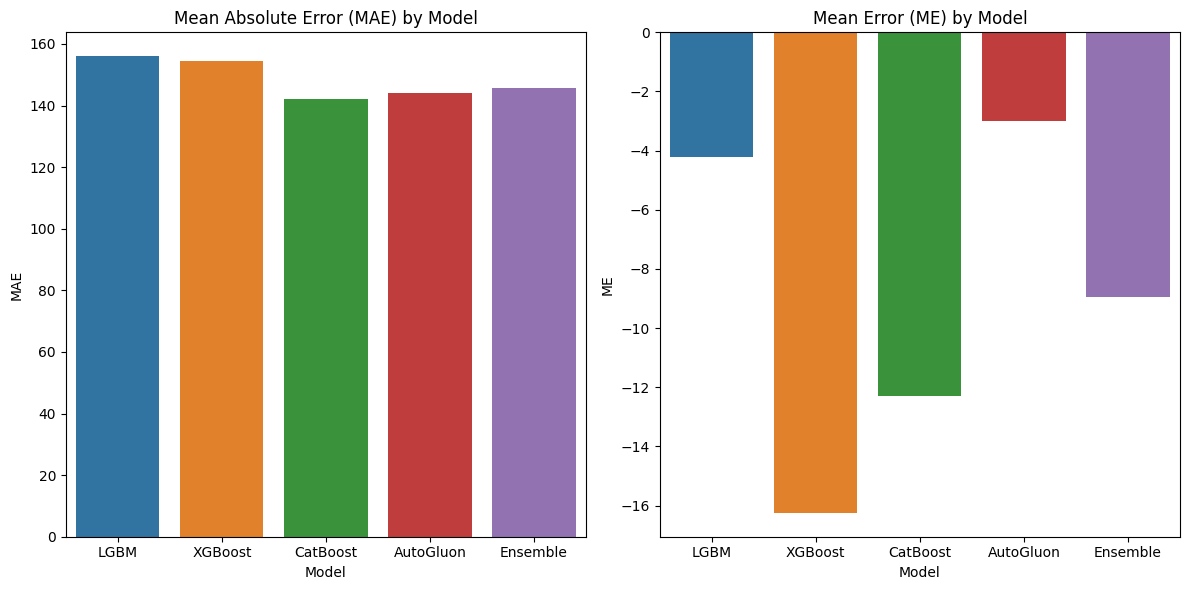

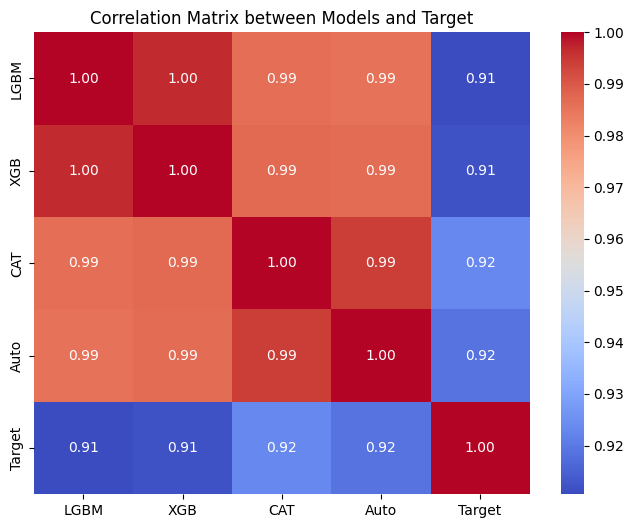

In [22]:
# Evaluate the models
y_pred_lgbm_A = lgbm_A.predict(X_val_A, num_iteration=lgbm_A.best_iteration)
y_pred_lgbm_B = lgbm_B.predict(X_val_B, num_iteration=lgbm_B.best_iteration)
y_pred_lgbm_C = lgbm_C.predict(X_val_C, num_iteration=lgbm_C.best_iteration)

y_pred_xgb_A = xgb_A.predict(X_val_A)
y_pred_xgb_B = xgb_B.predict(X_val_B)
y_pred_xgb_C = xgb_C.predict(X_val_C)

y_pred_cat_A = cat_A.predict(X_val_A)
y_pred_cat_B = cat_B.predict(X_val_B)
y_pred_cat_C = cat_C.predict(X_val_C)

y_pred_auto_A = auto_A.predict(val_auto_A)
y_pred_auto_B = auto_B.predict(val_auto_B)
y_pred_auto_C = auto_C.predict(val_auto_C)

y_pred_A = (y_pred_lgbm_A + y_pred_xgb_A + y_pred_cat_A + y_pred_auto_A) / 4
y_pred_B = (y_pred_lgbm_B + y_pred_xgb_B + y_pred_cat_B + y_pred_auto_B) / 4
y_pred_C = (y_pred_lgbm_C + y_pred_xgb_C + y_pred_cat_C + y_pred_auto_C) / 4

mae_lgbm = (mean_absolute_error(y_val_A, y_pred_lgbm_A) + mean_absolute_error(y_val_B, y_pred_lgbm_B) + mean_absolute_error(y_val_C, y_pred_lgbm_C)) / 3
me_lgbm = (np.mean(y_val_A - y_pred_lgbm_A) + np.mean(y_val_B - y_pred_lgbm_B) + np.mean(y_val_C - y_pred_lgbm_C)) / 3

mae_xgb = (mean_absolute_error(y_val_A, y_pred_xgb_A) + mean_absolute_error(y_val_B, y_pred_xgb_B) + mean_absolute_error(y_val_C, y_pred_xgb_C)) / 3
me_xgb = (np.mean(y_val_A - y_pred_xgb_A) + np.mean(y_val_B - y_pred_xgb_B) + np.mean(y_val_C - y_pred_xgb_C)) / 3

mae_cat = (mean_absolute_error(y_val_A, y_pred_cat_A) + mean_absolute_error(y_val_B, y_pred_cat_B) + mean_absolute_error(y_val_C, y_pred_cat_C)) / 3
me_cat = (np.mean(y_val_A - y_pred_cat_A) + np.mean(y_val_B - y_pred_cat_B) + np.mean(y_val_C - y_pred_cat_C)) / 3

mae_auto = (mean_absolute_error(y_val_A, y_pred_auto_A) + mean_absolute_error(y_val_B, y_pred_auto_B) + mean_absolute_error(y_val_C, y_pred_auto_C)) / 3
me_auto = (np.mean(y_val_A - y_pred_auto_A) + np.mean(y_val_B - y_pred_auto_B) + np.mean(y_val_C - y_pred_auto_C)) / 3

mae_ensemble = (mean_absolute_error(y_val_A, y_pred_A) + mean_absolute_error(y_val_B, y_pred_B) + mean_absolute_error(y_val_C, y_pred_C)) / 3
me_ensemble = (np.mean(y_val_A - y_pred_A) + np.mean(y_val_B - y_pred_B) + np.mean(y_val_C - y_pred_C)) / 3


data = {
    'Model': ['LGBM', 'XGBoost', 'CatBoost', 'AutoGluon', 'Ensemble'],
    'MAE': [mae_lgbm, mae_xgb, mae_cat, mae_auto, mae_ensemble],
    'ME': [me_lgbm, me_xgb, me_cat, me_auto, me_ensemble]
}
df = pd.DataFrame(data)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# MAE Plot
sns.barplot(x='Model', y='MAE', data=df, ax=ax[0])
ax[0].set_title('Mean Absolute Error (MAE) by Model')
ax[0].set_ylabel('MAE')
ax[0].set_xlabel('Model')

# ME Plot
sns.barplot(x='Model', y='ME', data=df, ax=ax[1])
ax[1].set_title('Mean Error (ME) by Model')
ax[1].set_ylabel('ME')
ax[1].set_xlabel('Model')

plt.tight_layout()
plt.show()


# Correlation between models
predictions = {
    'LGBM': y_pred_lgbm_A,
    'XGB': y_pred_xgb_A,
    'CAT': y_pred_cat_A,
    'Auto': y_pred_auto_A,
    'Target': y_val_A
}

df = pd.DataFrame(predictions)

# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix between Models and Target")
plt.show()

# LGBM MAE: 164.66193907310586
# LGBM ME:  -3.283997406364058
# XGBoost MAE: 163.58232480836227
# XGBoost ME:  -14.396179609256535
# CatBoost MAE: 153.72376266648897
# CatBoost ME:  -14.596797635277959
# AutoGluon MAE: 153.2338752051823
# AutoGluon ME:  -12.866129698126997
# MAE: 155.94795228615826
# ME:  -11.285776087256385
# LGBM X XGB: 0.9968981255356796
# LGBM X CAT: 0.9883593204716378
# LGBM X Auto: 0.9897584496126799
# XGB X CAT: 0.9895879160377353
# XGB X Auto: 0.990503482296124
# CAT X Auto: 0.9938514579173088
# Corr target: 0.9005127492063782